In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
import json
import string
import pymorphy2
import lightfm

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm_notebook
from multiprocessing import cpu_count, Pool

In [2]:
punctuation = string.punctuation
mapping = str.maketrans(punctuation, ' ' * len(punctuation))
ma = pymorphy2.MorphAnalyzer()

def normalize_text(s):
    normalized_splitted = [ma.normal_forms(word)[0] for word in s.translate(mapping).lower().split()]
    return " ".join(normalized_splitted)

def normalize_line(line):
    item = json.loads(line)
    item['content'] = normalize_text(item['content'])
    item['title'] = normalize_text(item['title'])
    if isinstance(item['image'], float):
        item['image'] = np.zeros((96,))
    else:
        item['image'] = np.array(item['image'])
    return item

In [9]:
items = pd.read_csv('../../data/processed/processed_items.csv', index_col='itemId')

In [3]:
with open('items.json') as items_json:
    with Pool(cpu_count()) as pool:
        items_json_list = list(pool.imap(normalize_line, items_json))
        
items = pd.DataFrame(items_json_list)
items.set_index('itemId')
items.head()

,content,itemId,image,title
0,согласиться дорогой любитель собака до что же ...,0,"[-0.169, 0.129, 0.067, 0.019, 0.281, -0.245, 0...",пять забавный морщинистый порода собака
1,контур три поперечный улица состоять до недавн...,1,"[-0.158, -0.112, -0.325, 0.05, -0.114, 0.002, ...",история улица ирининский в гомель
2,источник http infodays ru вообще он как то сам...,2,"[0.084, -0.181, 0.008, 0.34, -0.03, -0.197, -0...",зачем дудь весь время спрашивать гость програм...
3,41 летний светлана зейналов решить окрестить 5...,3,"[0.034, -0.119, -0.062, 0.025, 0.128, -0.041, ...",светлана зейналов крестить младший дочь
4,организовать преступный группировка гбао делат...,4,"[-0.061, -0.015, -0.198, -0.047, 0.054, 0.029,...",гкнб бандит в гбао делать вид что расстаться с...


In [17]:
items.loc[items.title.isna(), 'title'] = ''

In [10]:
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/valeriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
vectorizer = TfidfVectorizer(lowercase=False,
                             ngram_range=(1, 2),
                             min_df=50,
                             max_df=0.01,
                             stop_words=stopwords.words('russian'))
title_tfidf = vectorizer.fit_transform(items['title'])
title_tfidf.shape

(328050, 6999)

In [19]:
import gc
gc.collect()

0

In [20]:
item_features = scipy.sparse.hstack((scipy.sparse.eye(items.shape[0]), 
                                     title_tfidf),
                                    format='csr')

In [37]:
item_features.shape, title_tfidf.shape, items.shape[0]

((328050, 335049), (328050, 6999), 328050)

In [21]:
ratings = []
row = []
col = []

train_lines = sum(1 for line in open('train.json','r'))

with open('train.json') as train_file:
    for i, line in enumerate(tqdm_notebook(train_file, total=train_lines)):
        json_line = json.loads(line)
        for item, rating in json_line['trainRatings'].items():
            ratings.append(2 * int(rating) - 1)
            row.append(i)
            col.append(int(item))
train_int = scipy.sparse.coo_matrix((ratings, (row, col)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [22]:
model = lightfm.LightFM(no_components=128, loss='logistic', learning_schedule='adadelta', random_state=42)
model.fit(train_int, epochs=4, num_threads=cpu_count(), item_features=item_features, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3


In [47]:
item_biases, item_embeddings = model.get_item_representations(features=item_features)
item_biases.shape, item_embeddings.shape

((328050,), (328050, 128))

In [48]:
item_embeddings = np.hstack((item_embeddings, item_biases.reshape(-1, 1)))
gc.collect()

28

In [16]:
# del train_int
# gc.collect()

ratings = []
row = []
col = []

with open('train.json') as train_file:
    train_lines = sum(1 for line in train_file)

with open('train.json') as train_file:
    for i, line in enumerate(tqdm_notebook(train_file, total=train_lines)):
        json_line = json.loads(line)
        for item, rating in json_line['trainRatings'].items():
            ratings.append(int(rating))
            row.append(i)
            col.append(int(item))
train_int = scipy.sparse.coo_matrix((ratings, (row, col))).tocsc()

items_clicked = np.array(train_int.sum(axis=0))[0]
items_clicked = items_clicked / train_int.shape[0]
np.max(items_clicked), np.min(items_clicked)

(0.07776252414081951, 0.0)

In [27]:
threshold_ctr = np.percentile(items_clicked, 90)
threshold_ctr

0.0008376573516066734

In [31]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA(n_components=2, random_state=42)
embs_lower = pca.fit_transform(item_embeddings)
print(f'Explained variance: {sum(pca.explained_variance_ratio_):.3f}')

Explained variance: 0.643


In [2]:
import seaborn as sns
sns.set()

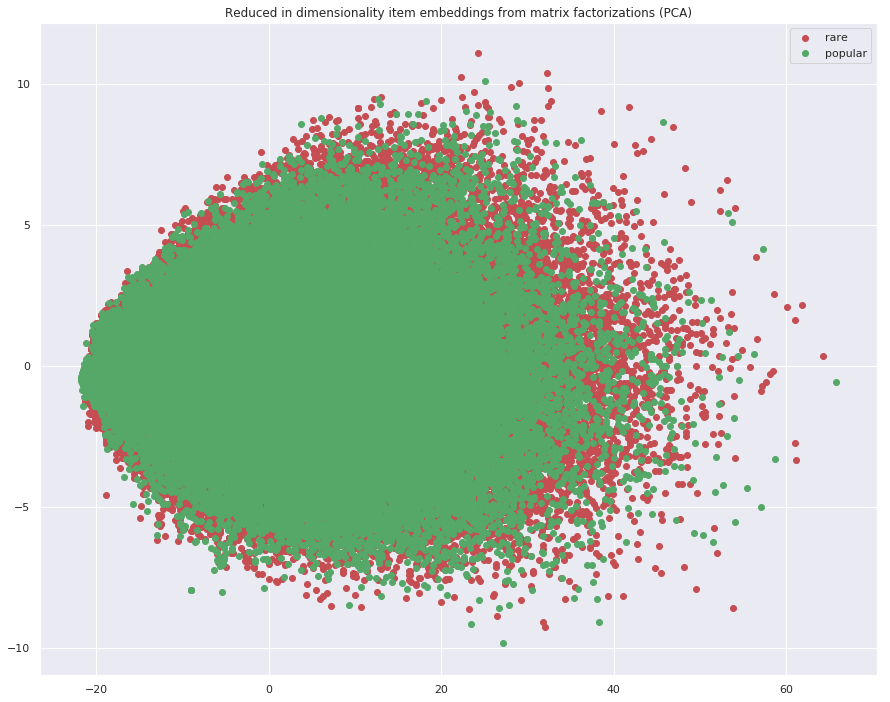

In [93]:
plt.figure(figsize=(15, 12))
plt.title('Reduced in dimensionality item embeddings from matrix factorizations (PCA)')
plt.scatter(embs_lower[items_clicked < threshold_ctr, 0], 
            embs_lower[items_clicked < threshold_ctr, 1], 
            c='r',
            label='rare')
plt.scatter(embs_lower[items_clicked >= threshold_ctr, 0], 
            embs_lower[items_clicked >= threshold_ctr, 1], 
            c='g',
            label='popular')
plt.savefig('../../reports/figures/item_embeddings_lightfm_pca.png')
plt.legend()
plt.show()

In [94]:
np.save('item_embs_lightfm', item_embeddings)

In [3]:
item_embeddings = np.load('item_embs_lightfm.npy')

In [4]:
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
from openTSNE import initialization

In [ ]:
%%time
affinities = affinity.PerplexityBasedNN(
    item_embeddings,
    perplexity=500,
    method="approx",
    n_jobs=10,
    random_state=42,
)

/home/vnkljukin/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [7]:
init = initialization.pca(item_embeddings, n_components=50, random_state=42)

In [8]:
tsne = TSNE(
    perplexity=50,
    metric="euclidean",
    n_jobs=10,
    random_state=42,
)

%time embedding_train = tsne.fit(init)

/home/vnkljukin/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


CPU times: user 1h 36min 36s, sys: 33min 35s, total: 2h 10min 11s
Wall time: 10min 32s


In [11]:
import tsne_utils

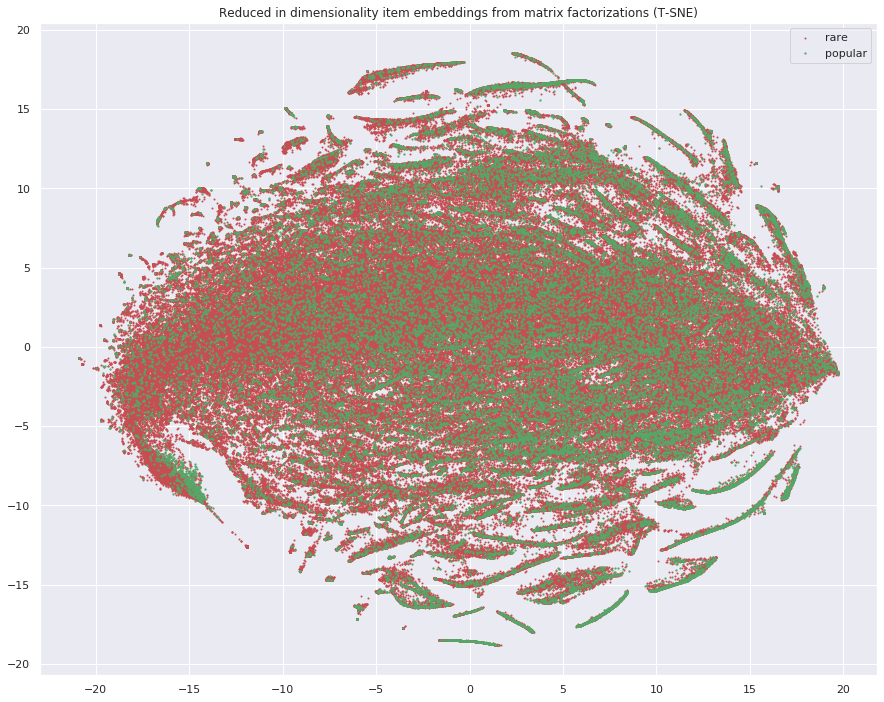

In [28]:
plt.figure(figsize=(15, 12))
plt.title('Reduced in dimensionality item embeddings from matrix factorizations (T-SNE)')
plt.scatter(embedding_train[items_clicked < threshold_ctr, 0], 
            embedding_train[items_clicked < threshold_ctr, 1], 
            c='r',
            label='rare', s=1)
plt.scatter(embedding_train[items_clicked >= threshold_ctr, 0], 
            embedding_train[items_clicked >= threshold_ctr, 1], 
            c='g',
            label='popular', s=1)
plt.savefig('item_embeddings_lightfm_pca_tsne.png')
plt.legend()
plt.show()

In [50]:
submission = pd.read_csv('random_benchmark.csv')
submission['y_pred'] = model.predict(
    submission['userId'].values,
    submission['itemId'].values,
    item_features=item_features,
    num_threads=cpu_count(),
)
submission.sort_values(['userId', 'y_pred'], ascending=[True, False], inplace=True)
submission.drop(columns=['y_pred'], inplace=True)
submission.to_csv('lightfm_title_tfidf_log.csv', index=False)